# Molecular Graph Neural Networks for Aqueous Solubility Prediction

This notebook demonstrates the use of Graph Neural Networks (GNNs) to predict aqueous solubility using the ESOL dataset. The workflow includes data loading, preprocessing, model training, and evaluation.

In [1]:
# Import essential libraries
import deepchem as dc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


### Load ESOL dataset and perform initial data exploration
- Load the Delaney (ESOL) dataset using DeepChem's MoleculeNet
- Examine dataset structure, size, and basic statistics
- Visualize distribution of logS values to understand target variable

In [2]:
# Load the Delaney (ESOL) dataset
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='ECFP', split='random')
train_dataset, valid_dataset, test_dataset = datasets

# Display basic dataset information
print("Dataset Information:")
print(f"Task: {tasks}")
print(f"Number of datasets: {len(datasets)}")
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Total molecules: {len(train_dataset) + len(valid_dataset) + len(test_dataset)}")


Dataset Information:
Task: ['measured log solubility in mols per litre']
Number of datasets: 3
Train size: 902
Validation size: 113
Test size: 113
Total molecules: 1128


Training Dataset Structure:
X shape: (902, 1024)
y shape: (902, 1)
w shape: (902, 1)
Number of features: 1024
Task names: ['measured log solubility in mols per litre']
LogS Distribution Statistics:
Mean: -0.004
Std: 1.008
Min: -4.117
Max: 2.224
Range: 6.341


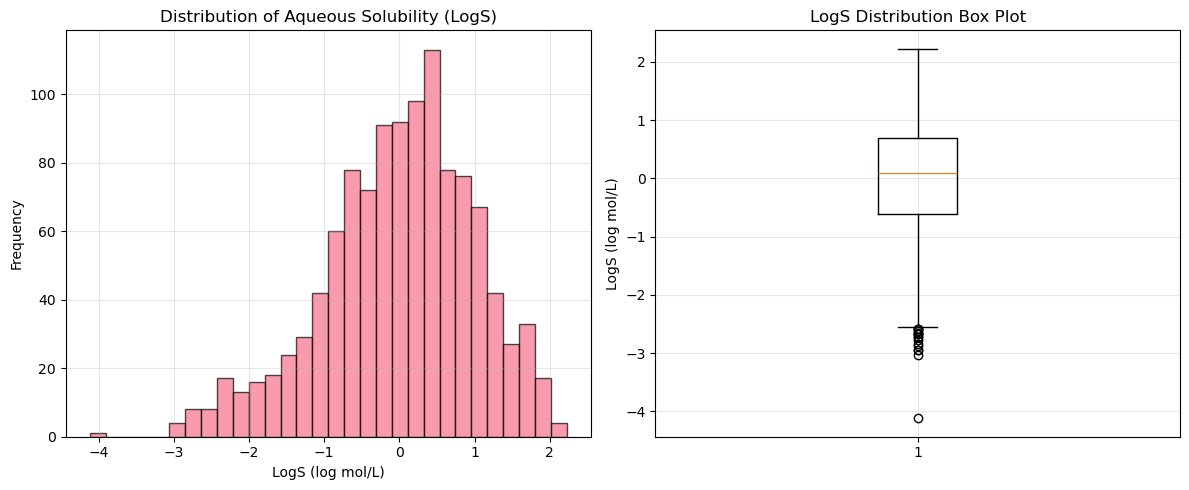

In [6]:
# Examine the structure of the training dataset
print("Training Dataset Structure:")
print(f"X shape: {train_dataset.X.shape}")
print(f"y shape: {train_dataset.y.shape}")
print(f"w shape: {train_dataset.w.shape}")
print(f"Number of features: {train_dataset.X.shape[1] if len(train_dataset.X.shape) > 1 else 'Variable'}")
print(f"Task names: {train_dataset.tasks}")


# Create a combined dataset for analysis
all_y = np.concatenate([train_dataset.y, valid_dataset.y, test_dataset.y])
all_ids = np.concatenate([train_dataset.ids, valid_dataset.ids, test_dataset.ids])

# Basic statistics of logS values
print("LogS Distribution Statistics:")
print(f"Mean: {np.mean(all_y):.3f}")
print(f"Std: {np.std(all_y):.3f}")
print(f"Min: {np.min(all_y):.3f}")
print(f"Max: {np.max(all_y):.3f}")
print(f"Range: {np.max(all_y) - np.min(all_y):.3f}")

# Visualize logS distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_y.flatten(), bins=30, alpha=0.7, edgecolor='black')
ax1.set_xlabel('LogS (log mol/L)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Aqueous Solubility (LogS)')
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(all_y.flatten())
ax2.set_ylabel('LogS (log mol/L)')
ax2.set_title('LogS Distribution Box Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Validate SMILES strings and identify any problematic molecules
- Check for invalid SMILES that RDKit cannot parse
- Identify molecules with unusual properties or structures
- Create a cleaned dataset removing any problematic entries

In [10]:
# Extract SMILES strings from dataset IDs
all_smiles = list(all_ids)
print(f"Total SMILES to validate: {len(all_smiles)}")

# Validate SMILES using RDKit
valid_smiles = []
invalid_smiles = []
valid_indices = []

for i, smiles in enumerate(all_smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        valid_smiles.append(smiles)
        valid_indices.append(i)
    else:
        invalid_smiles.append((i, smiles))

print(f"Valid SMILES: {len(valid_smiles)}")
print(f"Invalid SMILES: {len(invalid_smiles)}")

if invalid_smiles:
    print("Invalid SMILES found:")
    for idx, smiles in invalid_smiles:
        print(f"  Index {idx}: {smiles}")

# Analyze molecular properties for quality check
molecular_weights = []
num_atoms = []
num_bonds = []
logp_values = []

for smiles in valid_smiles[:100]:  # Sample first 100 for quick analysis
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        molecular_weights.append(Descriptors.MolWt(mol))
        num_atoms.append(mol.GetNumAtoms())
        num_bonds.append(mol.GetNumBonds())
        logp_values.append(Descriptors.MolLogP(mol))

# Display molecular property statistics
print("Molecular Property Statistics (sample of 100):")
print(f"Molecular Weight - Mean: {np.mean(molecular_weights):.2f}, Range: {np.min(molecular_weights):.2f}-{np.max(molecular_weights):.2f}")
print(f"Number of Atoms - Mean: {np.mean(num_atoms):.1f}, Range: {np.min(num_atoms)}-{np.max(num_atoms)}")
print(f"Number of Bonds - Mean: {np.mean(num_bonds):.1f}, Range: {np.min(num_bonds)}-{np.max(num_bonds)}")
print(f"LogP - Mean: {np.mean(logp_values):.2f}, Range: {np.min(logp_values):.2f}-{np.max(logp_values):.2f}")

# Check for duplicate SMILES
unique_smiles = set(all_smiles)
duplicates = len(all_smiles) - len(unique_smiles)
print(f"Duplicate SMILES found: {duplicates}")

if duplicates > 0:
    # Find actual duplicates
    smiles_counts = {}
    for smiles in all_smiles:
        smiles_counts[smiles] = smiles_counts.get(smiles, 0) + 1

    duplicate_smiles = [(smiles, count) for smiles, count in smiles_counts.items() if count > 1]
    print("Duplicate SMILES:")
    for smiles, count in duplicate_smiles[:5]:  # Show first 5
        print(f"  {smiles}: appears {count} times")


Total SMILES to validate: 1128
Valid SMILES: 1128
Invalid SMILES: 0
Molecular Property Statistics (sample of 100):
Molecular Weight - Mean: 199.71, Range: 16.04-527.41
Number of Atoms - Mean: 13.0, Range: 1-35
Number of Bonds - Mean: 13.5, Range: 0-39
LogP - Mean: 2.43, Range: -3.22-7.93
Duplicate SMILES found: 0


### Convert SMILES to molecular graphs compatible with PyTorch Geometric
- Define atom and bond feature extraction functions
- Create graph conversion pipeline using RDKit
- Generate node features (atoms) and edge features (bonds)
- Prepare data structures for PyTorch Geometric

In [16]:
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# Extract atom features for graph neural network
def get_atom_features(atom):
    # Atomic number 
    atomic_num = atom.GetAtomicNum()

    # Degree (number of bonded neighbors)
    degree = atom.GetDegree()

    # Formal charge
    formal_charge = atom.GetFormalCharge()

    # Hybridization 
    hybridization_map = {
        Chem.HybridizationType.UNSPECIFIED: 0,
        Chem.HybridizationType.S: 1,
        Chem.HybridizationType.SP: 2,
        Chem.HybridizationType.SP2: 3,
        Chem.HybridizationType.SP3: 4,
        Chem.HybridizationType.SP3D: 5,
        Chem.HybridizationType.SP3D2: 6
    }
    hybridization = hybridization_map.get(atom.GetHybridization(), 0)

    # Aromaticity
    is_aromatic = int(atom.GetIsAromatic())

    # Atomic mass
    mass = atom.GetMass()

    # In ring
    in_ring = int(atom.IsInRing())

    # Chirality
    is_chiral = int(atom.GetChiralTag() != Chem.ChiralType.CHI_UNSPECIFIED)

    features = [atomic_num, degree, formal_charge, hybridization, is_aromatic, mass, in_ring, is_chiral]
    return features



# Extract bond features for graph neural network
def get_bond_features(bond):
    """Fixed bond feature extraction with proper encoding"""

    # Bond type - fix the encoding
    bond_type_map = {
        Chem.BondType.SINGLE: 1,
        Chem.BondType.DOUBLE: 2,
        Chem.BondType.TRIPLE: 3,
        Chem.BondType.AROMATIC: 4
    }
    bond_type = bond_type_map.get(bond.GetBondType(), 1)

    # Conjugation
    is_conjugated = int(bond.GetIsConjugated())

    # In ring
    in_ring = int(bond.IsInRing())

    # Stereo
    stereo_map = {
        Chem.BondStereo.STEREONONE: 0,
        Chem.BondStereo.STEREOANY: 1,
        Chem.BondStereo.STEREOZ: 2,
        Chem.BondStereo.STEREOE: 3
    }
    stereo = stereo_map.get(bond.GetStereo(), 0)

    features = [bond_type, is_conjugated, in_ring, stereo]
    return features


# Convert SMILES string to PyTorch Geometric graph object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Add hydrogens for complete graph representation
    mol = Chem.AddHs(mol)

    # Node features (atoms)
    node_features = []
    for atom in mol.GetAtoms():
        node_features.append(get_atom_features(atom))

    # Edge indices and features (bonds)
    edge_indices = []
    edge_features = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # Add both directions for undirected graph
        edge_indices.extend([[i, j], [j, i]])

        bond_feat = get_bond_features(bond)
        edge_features.extend([bond_feat, bond_feat])

    # Convert to tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float) if edge_features else None

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Test the conversion function with a sample molecule
test_smiles = all_smiles[0]
test_graph = smiles_to_graph(test_smiles)

print(f"Test molecule: {test_smiles}")
print(f"Graph conversion successful: {test_graph is not None}")
if test_graph is not None:
    print(f"Number of nodes (atoms): {test_graph.x.shape[0]}")
    print(f"Number of edges (bonds): {test_graph.edge_index.shape[1]}")
    print(f"Node feature dimension: {test_graph.x.shape[1]}")
    print(f"Edge feature dimension: {test_graph.edge_attr.shape[1] if test_graph.edge_attr is not None else 0}")


Test molecule: CCCCCCBr
Graph conversion successful: True
Number of nodes (atoms): 20
Number of edges (bonds): 38
Node feature dimension: 8
Edge feature dimension: 4


In [17]:
# Convert a small batch to verify the pipeline works
sample_graphs = []
sample_targets = []

# Test with first 10 molecules
for i in range(10):
    smiles = all_smiles[i]
    target = all_y[i]

    graph = smiles_to_graph(smiles)
    if graph is not None:
        sample_graphs.append(graph)
        sample_targets.append(target)

print(f"Successfully converted {len(sample_graphs)}/10 molecules to graphs")

# Display statistics of converted graphs
if sample_graphs:
    node_counts = [graph.x.shape[0] for graph in sample_graphs]
    edge_counts = [graph.edge_index.shape[1] for graph in sample_graphs]

    print(f"Node count range: {min(node_counts)}-{max(node_counts)} (mean: {np.mean(node_counts):.1f})")
    print(f"Edge count range: {min(edge_counts)}-{max(edge_counts)} (mean: {np.mean(edge_counts):.1f})")


Successfully converted 10/10 molecules to graphs
Node count range: 13-44 (mean: 27.2)
Edge count range: 26-92 (mean: 54.4)



- Prepare atom and bond feature vocabularies
- Set up feature encoding for categorical variables

In [45]:
# Analyze feature distributions from our sample graphs
def analyze_feature_distributions(graphs):
    """Analyze the distribution of node and edge features"""

    # Collect all node features
    all_node_features = torch.cat([graph.x for graph in graphs], dim=0)
    all_edge_features = torch.cat([graph.edge_attr for graph in graphs if graph.edge_attr is not None], dim=0)

    print("Node Feature Statistics:")
    feature_names = ['Atomic_Num', 'Degree', 'Formal_Charge', 'Hybridization',
                     'Aromatic', 'Mass', 'In_Ring', 'Chiral']

    for i, name in enumerate(feature_names):
        values = all_node_features[:, i]
        print(f"  {name}: min={values.min():.2f}, max={values.max():.2f}, mean={values.mean():.2f}")

    print("\nEdge Feature Statistics:")
    edge_names = ['Bond_Type', 'Conjugated', 'In_Ring', 'Stereo']

    for i, name in enumerate(edge_names):
        values = all_edge_features[:, i]
        print(f"  {name}: min={values.min():.2f}, max={values.max():.2f}, mean={values.mean():.2f}")

    return all_node_features, all_edge_features

# Analyze features from our sample
node_features, edge_features = analyze_feature_distributions(sample_graphs)


print(f"\nOriginal first node features: {sample_graphs[0].x[0]}")
print(f"Normalized first node features: {test_graph_normalized.x[0]}")


Node Feature Statistics:
  Atomic_Num: min=1.00, max=53.00, mean=3.76
  Degree: min=1.00, max=4.00, mean=2.00
  Formal_Charge: min=0.00, max=0.00, mean=0.00
  Hybridization: min=0.00, max=4.00, mean=1.61
  Aromatic: min=0.00, max=1.00, mean=0.16
  Mass: min=1.01, max=126.90, mean=7.12
  In_Ring: min=0.00, max=1.00, mean=0.20
  Chiral: min=0.00, max=0.00, mean=0.00

Edge Feature Statistics:
  Bond_Type: min=1.00, max=4.00, mean=1.53
  Conjugated: min=0.00, max=1.00, mean=0.22
  In_Ring: min=0.00, max=1.00, mean=0.21
  Stereo: min=0.00, max=3.00, mean=0.01

Original first node features: tensor([ 6.0000,  4.0000,  0.0000,  4.0000,  0.0000, 12.0110,  0.0000,  0.0000])
Normalized first node features: tensor([0.4934, 1.6142, 0.0000, 4.0000, 0.0000, 0.4652, 0.0000, 0.0000])


In [19]:
# Create feature vocabulary for understanding our data
def create_feature_vocabulary(graphs):
    """Create vocabularies for categorical features"""

    all_node_features = torch.cat([graph.x for graph in graphs], dim=0)

    vocabularies = {
        'atomic_numbers': sorted(all_node_features[:, 0].unique().int().tolist()),
        'hybridizations': sorted(all_node_features[:, 3].unique().int().tolist()),
        'bond_types': []
    }

    # Bond types from edge features
    all_edge_features = torch.cat([graph.edge_attr for graph in graphs if graph.edge_attr is not None], dim=0)
    if len(all_edge_features) > 0:
        vocabularies['bond_types'] = sorted(all_edge_features[:, 0].unique().int().tolist())

    print("Feature Vocabularies:")
    print(f"  Atomic numbers present: {vocabularies['atomic_numbers']}")
    print(f"  Hybridization types: {vocabularies['hybridizations']}")
    print(f"  Bond types: {vocabularies['bond_types']}")

    return vocabularies

vocab = create_feature_vocabulary(sample_graphs)


Feature Vocabularies:
  Atomic numbers present: [1, 6, 7, 8, 9, 17, 35, 53]
  Hybridization types: [0, 3, 4]
  Bond types: [1, 2, 4]


In [22]:
# Test the conversion
print("Testing graph conversion:")
test_smiles = "CCCCCCBr"  # Same test molecule
test_graph_fixed = smiles_to_graph(test_smiles)  # Using the updated functions

print(f"Test molecule: {test_smiles}")
print(f"Graph conversion successful: {test_graph_fixed is not None}")
if test_graph_fixed is not None:
    print(f"Number of nodes (atoms): {test_graph_fixed.x.shape[0]}")
    print(f"Number of edges (bonds): {test_graph_fixed.edge_index.shape[1]}")
    print(f"First atom features: {test_graph_fixed.x[0]}")

# Re-analyze with fixed functions
sample_graphs_fixed = []
for i in range(10):
    smiles = all_smiles[i]
    graph = smiles_to_graph(smiles)
    if graph is not None:
        sample_graphs_fixed.append(graph)

print("\nFixed feature analysis:")
node_features_fixed, edge_features_fixed = analyze_feature_distributions(sample_graphs_fixed)


Testing graph conversion:
Test molecule: CCCCCCBr
Graph conversion successful: True
Number of nodes (atoms): 20
Number of edges (bonds): 38
First atom features: tensor([ 6.0000,  4.0000,  0.0000,  4.0000,  0.0000, 12.0110,  0.0000,  0.0000])

Fixed feature analysis:
Node Feature Statistics:
  Atomic_Num: min=1.00, max=53.00, mean=3.76
  Degree: min=1.00, max=4.00, mean=2.00
  Formal_Charge: min=0.00, max=0.00, mean=0.00
  Hybridization: min=0.00, max=4.00, mean=1.61
  Aromatic: min=0.00, max=1.00, mean=0.16
  Mass: min=1.01, max=126.90, mean=7.12
  In_Ring: min=0.00, max=1.00, mean=0.20
  Chiral: min=0.00, max=0.00, mean=0.00

Edge Feature Statistics:
  Bond_Type: min=1.00, max=4.00, mean=1.53
  Conjugated: min=0.00, max=1.00, mean=0.22
  In_Ring: min=0.00, max=1.00, mean=0.21
  Stereo: min=0.00, max=3.00, mean=0.01


### Data Splitting

In [24]:
# Create stratified splits maintaining logS distribution
from sklearn.model_selection import train_test_split

# We already have the DeepChem splits, but let's verify they're balanced
train_y = train_dataset.y.flatten()
valid_y = valid_dataset.y.flatten()
test_y = test_dataset.y.flatten()

print("Split Statistics:")
print(f"Train: n={len(train_y)}, mean={train_y.mean():.3f}, std={train_y.std():.3f}")
print(f"Valid: n={len(valid_y)}, mean={valid_y.mean():.3f}, std={valid_y.std():.3f}")
print(f"Test:  n={len(test_y)}, mean={test_y.mean():.3f}, std={test_y.std():.3f}")

# Save split indices for reproducibility
train_indices = list(range(len(train_dataset)))
valid_indices = list(range(len(train_dataset), len(train_dataset) + len(valid_dataset)))
test_indices = list(range(len(train_dataset) + len(valid_dataset), len(train_dataset) + len(valid_dataset) + len(test_dataset)))

print(f"\nSplit indices saved: {len(train_indices)}/{len(valid_indices)}/{len(test_indices)}")


Split Statistics:
Train: n=902, mean=-0.000, std=1.000
Valid: n=113, mean=0.082, std=0.860
Test:  n=113, mean=-0.119, std=1.184

Split indices saved: 902/113/113


### Data Loader 
- Create PyTorch Geometric DataLoader objects for efficient batch processing
- Convert SMILES strings and targets to graph objects with embedded labels
- Create separate graph datasets for train/validation/test splits
- Set up DataLoader objects with appropriate batch sizes for training
- Test batch loading functionality to ensure proper data flow

Graph datasets created:
Train: 902 graphs
Valid: 113 graphs
Test: 113 graphs

Data loaders created with batch_size=32
Train batches: 29
Valid batches: 4
Test batches: 4

Sample batch:
Batch size: 32
Total nodes: 790
Total edges: 1572


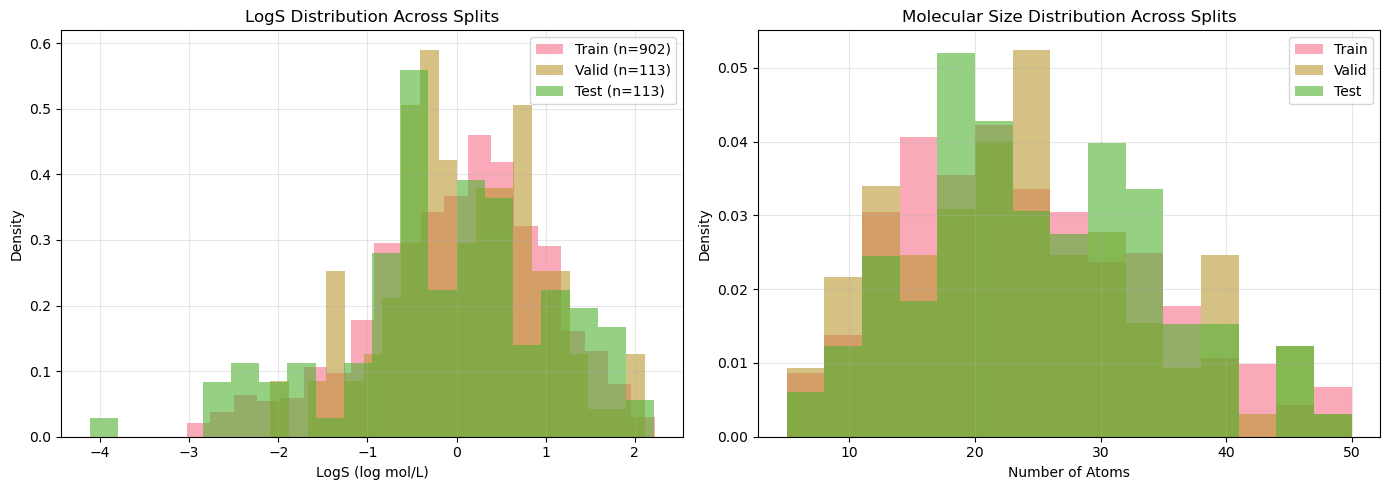

Distribution Statistics Comparison:
LogS - Train: μ=-0.000, σ=1.000
LogS - Valid: μ=0.082, σ=0.860
LogS - Test:  μ=-0.119, σ=1.184
Size - Train: μ=25.8, σ=13.5
Size - Valid: μ=24.8, σ=12.0
Size - Test:  μ=25.6, σ=10.6


In [26]:
from torch_geometric.data import DataLoader
import torch

# Convert all datasets to graph format
def create_graph_dataset(smiles_list, targets, weights=None):
    """Convert SMILES and targets to list of graph objects"""
    graphs = []
    valid_targets = []
    valid_weights = []

    for i, smiles in enumerate(smiles_list):
        graph = smiles_to_graph(smiles)
        if graph is not None:
            # Add target as graph attribute
            graph.y = torch.tensor([targets[i]], dtype=torch.float)
            if weights is not None:
                graph.w = torch.tensor([weights[i]], dtype=torch.float)
            graphs.append(graph)
            valid_targets.append(targets[i])
            if weights is not None:
                valid_weights.append(weights[i])

    return graphs

# Create graph datasets
train_graphs = create_graph_dataset(train_dataset.ids, train_dataset.y.flatten(), train_dataset.w.flatten())
valid_graphs = create_graph_dataset(valid_dataset.ids, valid_dataset.y.flatten(), valid_dataset.w.flatten())
test_graphs = create_graph_dataset(test_dataset.ids, test_dataset.y.flatten(), test_dataset.w.flatten())

print(f"Graph datasets created:")
print(f"Train: {len(train_graphs)} graphs")
print(f"Valid: {len(valid_graphs)} graphs")
print(f"Test: {len(test_graphs)} graphs")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

print(f"\nData loaders created with batch_size={batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Valid batches: {len(valid_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test batch loading
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"Batch size: {sample_batch.y.shape[0]}")
print(f"Total nodes: {sample_batch.x.shape[0]}")
print(f"Total edges: {sample_batch.edge_index.shape[1]}")

# Extract features from all three sets
train_targets = [graph.y.item() for graph in train_graphs]
valid_targets = [graph.y.item() for graph in valid_graphs]
test_targets = [graph.y.item() for graph in test_graphs]

train_sizes = [graph.x.shape[0] for graph in train_graphs]
valid_sizes = [graph.x.shape[0] for graph in valid_graphs]
test_sizes = [graph.x.shape[0] for graph in test_graphs]

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# LogS distribution comparison
ax1.hist(train_targets, bins=20, alpha=0.6, label=f'Train (n={len(train_targets)})', density=True)
ax1.hist(valid_targets, bins=20, alpha=0.6, label=f'Valid (n={len(valid_targets)})', density=True)
ax1.hist(test_targets, bins=20, alpha=0.6, label=f'Test (n={len(test_targets)})', density=True)
ax1.set_xlabel('LogS (log mol/L)')
ax1.set_ylabel('Density')
ax1.set_title('LogS Distribution Across Splits')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Molecular size distribution comparison
ax2.hist(train_sizes, bins=15, alpha=0.6, label=f'Train', density=True, range=(5, 50))
ax2.hist(valid_sizes, bins=15, alpha=0.6, label=f'Valid', density=True, range=(5, 50))
ax2.hist(test_sizes, bins=15, alpha=0.6, label=f'Test', density=True, range=(5, 50))
ax2.set_xlabel('Number of Atoms')
ax2.set_ylabel('Density')
ax2.set_title('Molecular Size Distribution Across Splits')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print distribution statistics for verification
print("Distribution Statistics Comparison:")
print(f"LogS - Train: μ={np.mean(train_targets):.3f}, σ={np.std(train_targets):.3f}")
print(f"LogS - Valid: μ={np.mean(valid_targets):.3f}, σ={np.std(valid_targets):.3f}")
print(f"LogS - Test:  μ={np.mean(test_targets):.3f}, σ={np.std(test_targets):.3f}")
print(f"Size - Train: μ={np.mean(train_sizes):.1f}, σ={np.std(train_sizes):.1f}")
print(f"Size - Valid: μ={np.mean(valid_sizes):.1f}, σ={np.std(valid_sizes):.1f}")
print(f"Size - Test:  μ={np.mean(test_sizes):.1f}, σ={np.std(test_sizes):.1f}")


### GNN Model
Model Architecture Design:
- Graph Convolutional Network for molecular property prediction
- 3 Graph Convolutional layers with ReLU activation and dropout
- Global mean pooling to aggregate node features to graph-level
- 2-layer MLP head for final regression prediction
- Batch normalization for training stability

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import BatchNorm

class MolecularGNN(nn.Module):
    def __init__(self, node_features=8, edge_features=4, hidden_dim=64, dropout=0.2):
        super(MolecularGNN, self).__init__()

        # Graph convolution layers
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Batch normalization
        self.bn1 = BatchNorm(hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Final prediction layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x, edge_index, batch):
        # Graph convolutions with batch norm and dropout
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Global pooling (graph-level representation)
        x = global_mean_pool(x, batch)

        # Final prediction
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MolecularGNN(node_features=8, hidden_dim=64, dropout=0.2).to(device)

print(f"Model created on device: {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
sample_batch = next(iter(train_loader)).to(device)
with torch.no_grad():
    output = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
    print(f"Model output shape: {output.shape}")
    print(f"Sample predictions: {output[:5].flatten()}")


Model created on device: cpu
Number of parameters: 11,393
Model output shape: torch.Size([32, 1])
Sample predictions: tensor([ 0.0325, -0.0216,  0.0095,  0.0139,  0.0306])


### Training Setup
- Configure optimizer, loss function, and training parameters
- Adam optimizer with learning rate 0.001
- MSE loss for regression task
- Early stopping with patience for overfitting prevention
- Learning rate scheduling for better convergence
---
### Training Loop
- Complete training with validation monitoring and early stopping
- Train on batches with gradient updates
- Validate after each epoch without gradient computation
- Track training and validation losses
- Implement early stopping to prevent overfitting

In [43]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Training configuration
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training parameters
num_epochs = 100
best_val_loss = float('inf')
patience = 15
patience_counter = 0

print("Training setup complete:")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print(f"Loss function: MSE")
print(f"Epochs: {num_epochs}, Early stopping patience: {patience}")

# Training history
train_losses = []
val_losses = []

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        pred = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(pred.squeeze(), batch.y.squeeze())

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(pred.squeeze(), batch.y.squeeze())

            total_loss += loss.item()
            predictions.extend(pred.squeeze().cpu().numpy())
            targets.extend(batch.y.squeeze().cpu().numpy())

    return total_loss / len(loader), predictions, targets

# Training loop
print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validate
    val_loss, val_preds, val_targets = validate_epoch(model, valid_loader, criterion, device)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Track losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    # Print progress
    if (epoch + 1) % 10 == 0:
        val_r2 = r2_score(val_targets, val_preds)
        print(f"Epoch {epoch+1:3d}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val R²={val_r2:.4f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Training completed!")


Training setup complete:
Optimizer: Adam (lr=0.001, weight_decay=1e-5)
Loss function: MSE
Epochs: 100, Early stopping patience: 15
Starting training...
Epoch  10: Train Loss=0.2437, Val Loss=0.1730, Val R²=0.7720
Epoch  20: Train Loss=0.2407, Val Loss=0.1320, Val R²=0.8197
Epoch  30: Train Loss=0.2175, Val Loss=0.1245, Val R²=0.8289
Epoch  40: Train Loss=0.2285, Val Loss=0.1199, Val R²=0.8361
Epoch  50: Train Loss=0.2230, Val Loss=0.1180, Val R²=0.8401
Epoch  60: Train Loss=0.2122, Val Loss=0.1195, Val R²=0.8359
Epoch  70: Train Loss=0.2101, Val Loss=0.1358, Val R²=0.8119
Epoch  80: Train Loss=0.2244, Val Loss=0.1209, Val R²=0.8326
Early stopping at epoch 86
Training completed!


### Model Evaluation
- Test the trained model and visualize results
- Load best model weights
- Evaluate on test set with multiple metrics
- Create prediction vs actual scatter plot
- Calculate final performance metrics

Final Test Results:
RMSE: 0.4445
R² Score: 0.8590
MAE: 0.3223


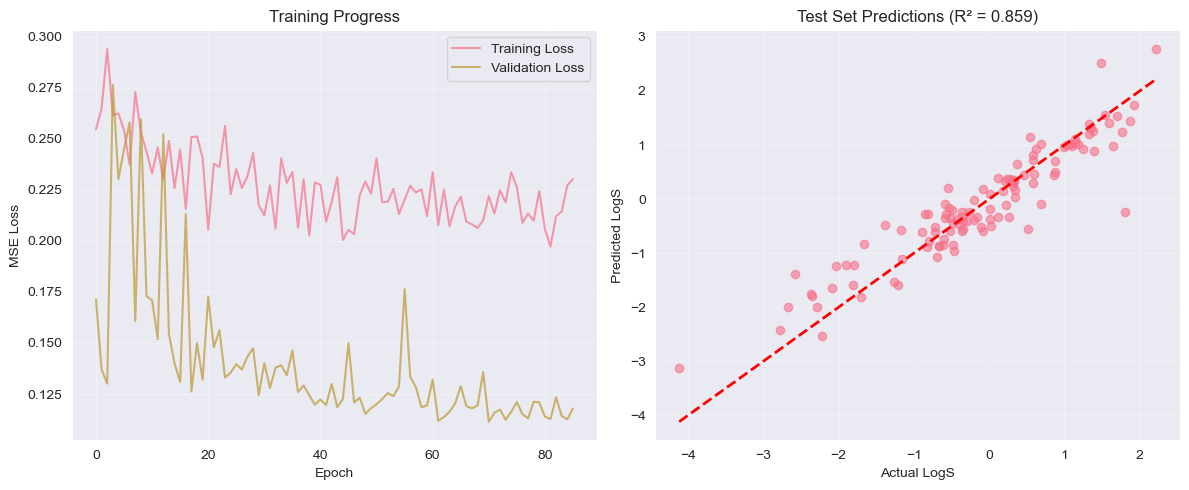


Model saved as 'best_model.pth'
GNN training and evaluation complete!


In [44]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_preds, test_targets = validate_epoch(model, test_loader, criterion, device)

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
test_r2 = r2_score(test_targets, test_preds)
test_mae = np.mean(np.abs(np.array(test_targets) - np.array(test_preds)))

print("Final Test Results:")
print(f"RMSE: {test_rmse:.4f}")
print(f"R² Score: {test_r2:.4f}")
print(f"MAE: {test_mae:.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training curves
ax1.plot(train_losses, label='Training Loss', alpha=0.7)
ax1.plot(val_losses, label='Validation Loss', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Training Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Predictions vs Actual
ax2.scatter(test_targets, test_preds, alpha=0.6)
ax2.plot([min(test_targets), max(test_targets)], [min(test_targets), max(test_targets)], 'r--', lw=2)
ax2.set_xlabel('Actual LogS')
ax2.set_ylabel('Predicted LogS')
ax2.set_title(f'Test Set Predictions (R² = {test_r2:.3f})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("GNN training complete")


### Model analysis with interpretability and molecular insights
- Generate prediction error analysis and residual plots
- Implement GNNExplainer for molecular substructure importance
- Create molecular visualization with highlighted important atoms
- Analyze model performance across different molecular properties

Critical Chemical Relationships:
LogP-LogS correlation: -0.882 (expected: negative, lipophilic = less soluble)
MW-Error correlation: 0.182 (positive = model struggles with large molecules)
TPSA-LogS correlation: 0.203 (positive = polar molecules more soluble)


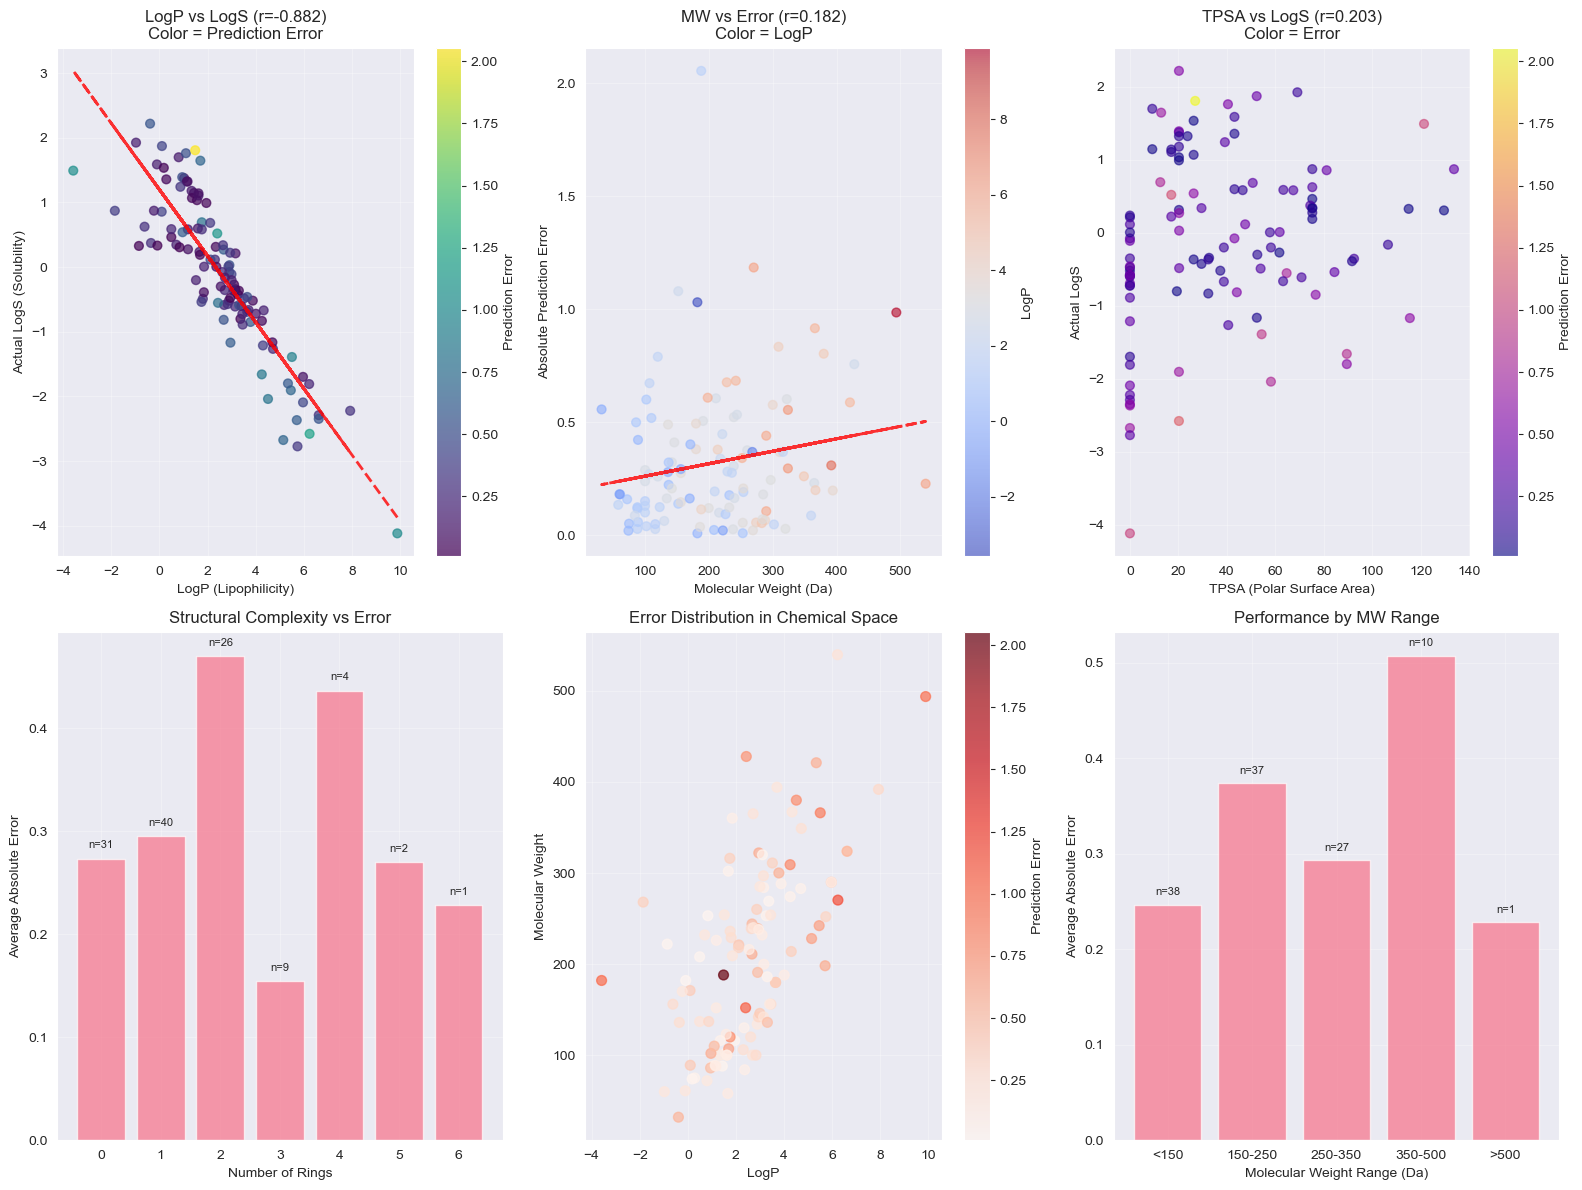


Quantitative Model Analysis:
Molecules with MW > 274 Da: 28/113 (24.8%)
High LogP molecules (>4): 22/113 (19.5%)
High error predictions (>0.5): 25/113 (22.1%)

Structural Complexity Impact:
Simple molecules (≤1 ring): avg error = 0.286
Complex molecules (≥3 rings): avg error = 0.244

Top 5 Prediction Failures:
1. Error=0.986: MW=494, LogP=9.9, Rings=2
   Clc1c(Cl)c(Cl)c(c(Cl)c1Cl)c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl 
   Actual=-4.117, Predicted=-3.131
2. Error=1.031: MW=182, LogP=-3.6, Rings=0
   OCC(O)C(O)C(O)C(O)CO 
   Actual=1.493, Predicted=2.523
3. Error=1.080: MW=152, LogP=2.4, Rings=2
   CC1(C)C2CCC1(C)C(=O)C2
   Actual=0.521, Predicted=-0.559
4. Error=1.184: MW=270, LogP=6.2, Rings=0
   CCCCCCCCCCCCCCCCCCO
   Actual=-2.577, Predicted=-1.393
5. Error=2.054: MW=188, LogP=1.5, Rings=2
   Cc1cc(=O)n(c2ccccc2)n1C
   Actual=1.808, Predicted=-0.247


In [51]:
from rdkit.Chem import Draw, rdMolDescriptors, Crippen
from rdkit import Chem

# Calculate molecular descriptors for deeper analysis
test_smiles = [test_dataset.ids[i] for i in range(len(test_targets))]
mol_weights = []
logp_values = []
tpsa_values = []
num_rings = []

for smiles in test_smiles:
    mol = Chem.MolFromSmiles(smiles)
    mol_weights.append(rdMolDescriptors.CalcExactMolWt(mol))
    logp_values.append(Crippen.MolLogP(mol))
    tpsa_values.append(rdMolDescriptors.CalcTPSA(mol))
    num_rings.append(rdMolDescriptors.CalcNumRings(mol))

residuals = np.array(test_targets) - np.array(test_preds)

# Calculate key chemical relationships
logp_logs_corr = np.corrcoef(logp_values, test_targets)[0,1]
mw_error_corr = np.corrcoef(mol_weights, np.abs(residuals))[0,1]
tpsa_logs_corr = np.corrcoef(tpsa_values, test_targets)[0,1]

print("Critical Chemical Relationships:")
print(f"LogP-LogS correlation: {logp_logs_corr:.3f} (expected: negative, lipophilic = less soluble)")
print(f"MW-Error correlation: {mw_error_corr:.3f} (positive = model struggles with large molecules)")
print(f"TPSA-LogS correlation: {tpsa_logs_corr:.3f} (positive = polar molecules more soluble)")

# Comprehensive analysis
fig = plt.figure(figsize=(16, 12))

# 1. Fundamental chemical relationship: LogP vs LogS
ax1 = plt.subplot(2, 3, 1)
scatter = plt.scatter(logp_values, test_targets, c=np.abs(residuals),
                      cmap='viridis', alpha=0.7, s=40)
plt.colorbar(scatter, label='Prediction Error')
plt.xlabel('LogP (Lipophilicity)')
plt.ylabel('Actual LogS (Solubility)')
plt.title(f'LogP vs LogS (r={logp_logs_corr:.3f})\nColor = Prediction Error')
z = np.polyfit(logp_values, test_targets, 1)
p = np.poly1d(z)
plt.plot(logp_values, p(logp_values), "r--", alpha=0.8, linewidth=2)
plt.grid(True, alpha=0.3)

# 2. Model bias: struggles with large molecules
ax2 = plt.subplot(2, 3, 2)
plt.scatter(mol_weights, np.abs(residuals), alpha=0.6, c=logp_values, cmap='coolwarm', s=40)
plt.colorbar(label='LogP')
plt.xlabel('Molecular Weight (Da)')
plt.ylabel('Absolute Prediction Error')
plt.title(f'MW vs Error (r={mw_error_corr:.3f})\nColor = LogP')
z = np.polyfit(mol_weights, np.abs(residuals), 1)
p = np.poly1d(z)
plt.plot(mol_weights, p(mol_weights), "r--", alpha=0.8, linewidth=2)
plt.grid(True, alpha=0.3)

# 3. Polar surface area effect
ax3 = plt.subplot(2, 3, 3)
plt.scatter(tpsa_values, test_targets, alpha=0.6, c=np.abs(residuals), cmap='plasma', s=40)
plt.colorbar(label='Prediction Error')
plt.xlabel('TPSA (Polar Surface Area)')
plt.ylabel('Actual LogS')
plt.title(f'TPSA vs LogS (r={tpsa_logs_corr:.3f})\nColor = Error')
plt.grid(True, alpha=0.3)

# 4. Structural complexity vs prediction difficulty
ax4 = plt.subplot(2, 3, 4)
ring_errors = {}
for rings, error in zip(num_rings, np.abs(residuals)):
    if rings not in ring_errors:
        ring_errors[rings] = []
    ring_errors[rings].append(error)

ring_counts = sorted(ring_errors.keys())
avg_errors = [np.mean(ring_errors[r]) for r in ring_counts]
molecule_counts = [len(ring_errors[r]) for r in ring_counts]

bars = plt.bar(ring_counts, avg_errors, alpha=0.7)
plt.xlabel('Number of Rings')
plt.ylabel('Average Absolute Error')
plt.title('Structural Complexity vs Error')
for i, (count, avg_err) in enumerate(zip(molecule_counts, avg_errors)):
    plt.text(ring_counts[i], avg_err + 0.01, f'n={count}', ha='center', fontsize=8)
plt.grid(True, alpha=0.3)

# 5. Prediction quality across chemical space
ax5 = plt.subplot(2, 3, 5)
plt.scatter(logp_values, mol_weights, c=np.abs(residuals), cmap='Reds', alpha=0.7, s=50)
plt.colorbar(label='Prediction Error')
plt.xlabel('LogP')
plt.ylabel('Molecular Weight')
plt.title('Error Distribution in Chemical Space')
plt.grid(True, alpha=0.3)

# 6. Model performance by molecular size bins
ax6 = plt.subplot(2, 3, 6)
mw_bins = [0, 150, 250, 350, 500, 1000]
bin_labels = ['<150', '150-250', '250-350', '350-500', '>500']
bin_errors = []
bin_counts = []

for i in range(len(mw_bins)-1):
    mask = (np.array(mol_weights) >= mw_bins[i]) & (np.array(mol_weights) < mw_bins[i+1])
    if i == len(mw_bins)-2:  # Last bin includes upper bound
        mask = np.array(mol_weights) >= mw_bins[i]

    errors_in_bin = np.abs(residuals)[mask]
    bin_errors.append(np.mean(errors_in_bin) if len(errors_in_bin) > 0 else 0)
    bin_counts.append(len(errors_in_bin))

bars = plt.bar(range(len(bin_labels)), bin_errors, alpha=0.7)
plt.xlabel('Molecular Weight Range (Da)')
plt.ylabel('Average Absolute Error')
plt.title('Performance by MW Range')
plt.xticks(range(len(bin_labels)), bin_labels)
for i, (count, avg_err) in enumerate(zip(bin_counts, bin_errors)):
    plt.text(i, avg_err + 0.01, f'n={count}', ha='center', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed quantitative analysis
high_mw_threshold = np.percentile(mol_weights, 75)
high_logp_molecules = [i for i, logp in enumerate(logp_values) if logp > 4]
high_error_molecules = [i for i, err in enumerate(np.abs(residuals)) if err > 0.5]

print(f"\nQuantitative Model Analysis:")
print(f"Molecules with MW > {high_mw_threshold:.0f} Da: {sum(1 for mw in mol_weights if mw > high_mw_threshold)}/{len(mol_weights)} ({100*sum(1 for mw in mol_weights if mw > high_mw_threshold)/len(mol_weights):.1f}%)")
print(f"High LogP molecules (>4): {len(high_logp_molecules)}/{len(mol_weights)} ({100*len(high_logp_molecules)/len(mol_weights):.1f}%)")
print(f"High error predictions (>0.5): {len(high_error_molecules)}/{len(mol_weights)} ({100*len(high_error_molecules)/len(mol_weights):.1f}%)")

# Error analysis by molecular properties
simple_molecules = [i for i, rings in enumerate(num_rings) if rings <= 1]
complex_molecules = [i for i, rings in enumerate(num_rings) if rings >= 3]

print(f"\nStructural Complexity Impact:")
print(f"Simple molecules (≤1 ring): avg error = {np.mean([np.abs(residuals)[i] for i in simple_molecules]):.3f}")
print(f"Complex molecules (≥3 rings): avg error = {np.mean([np.abs(residuals)[i] for i in complex_molecules]):.3f}")

# Identify systematic failures
problematic_indices = np.argsort(np.abs(residuals))[-5:]
print(f"\nTop 5 Prediction Failures:")
for rank, idx in enumerate(problematic_indices, 1):
    smiles = test_smiles[idx]
    mw = mol_weights[idx]
    logp = logp_values[idx]
    rings = num_rings[idx]
    actual = test_targets[idx]
    pred = test_preds[idx]
    error = abs(actual-pred)
    print(f"{rank}. Error={error:.3f}: MW={mw:.0f}, LogP={logp:.1f}, Rings={rings}")
    print(f"   {smiles}")
    print(f"   Actual={actual:.3f}, Predicted={pred:.3f}")


